<p align="center"><strong><font size="6">Programming Assignement 2 - Random Forests</font></strong></p>
<p align="center"><font size="5">Group 69</font></p>
<p align="center"><font size="5">Semir Sehic - Valentin Quoniam</font></p>

In [2]:
# Useful libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

<p align="center"><font size="6">Task 1</font></p>


Step 1 - Reading the data

In [3]:
# If the two csv files don't exist, download them.
if not os.path.exists('adult_train.csv'):
    !wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_train.csv --no-check-certificate
if not os.path.exists('adult_test.csv'):
    !wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_test.csv --no-check-certificate

# Read the data (and skip the first row, which is the column names)    
train_data = pd.read_csv('adult_train.csv', skiprows=0)
test_data = pd.read_csv('adult_test.csv', skiprows=0)

# Shuffle the datasets.
train_data_shuffled = train_data.sample(frac=1.0, random_state=0)
test_data_shuffled = test_data.sample(frac=1.0, random_state=0)

# Split into input part X and output part Y.
Xtrain = train_data_shuffled.drop('target', axis=1)
Xtest = test_data_shuffled.drop('target', axis=1)

Ytrain = train_data_shuffled['target']
Ytest = test_data_shuffled['target']

# Safety verification of the data
Xtrain.head()


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
22278,49,Local-gov,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States
8950,49,Private,HS-grad,9,Divorced,Other-service,Not-in-family,Black,Female,0,0,40,United-States
7838,31,Private,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States
16505,53,Private,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,43,United-States
19140,30,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States


Step 2 - Encoding the features as numbers

In [4]:
# Encoding the training data
dicts_for_Xtrain = Xtrain.to_dict('records')
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(dicts_for_Xtrain)

# Create a classifier compute the cross-validation accuracy for 5-fold cross-validation
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X_train_encoded, Ytrain)
print("Cross-validation accuracy :", scores.mean().round(3))

# Encoding the test data
dicts_for_Xtest = Xtest.to_dict('records')
X_test_encoded = dv.transform(dicts_for_Xtest)

y_pred = clf.fit(X_train_encoded, Ytrain).predict(X_test_encoded)
print("Test accuracy :", np.mean(y_pred == Ytest).round(3))



Cross-validation accuracy : 0.866
Test accuracy : 0.871


Step 3 - Combining the steps

In [5]:
# Let's combine all the processing steps into a single pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

pipeline=Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', GradientBoostingClassifier())
])

pipeline.fit(dicts_for_Xtrain, Ytrain)

# We can now use this pipeline to compute a cross-validation accuracy for the training set
scores = cross_val_score(pipeline, dicts_for_Xtrain, Ytrain)
print("Cross-validation accuracy :", scores.mean().round(3))

# And we can use it to compute the test accuracy
y_pred = pipeline.predict(dicts_for_Xtest)
print("Test accuracy :", round(accuracy_score(Ytest,y_pred),3))


Cross-validation accuracy : 0.866
Test accuracy : 0.871


<p align="center"><font size="6">Task 2</font></p>

Underfitting and overfitting in decision tree classifiers

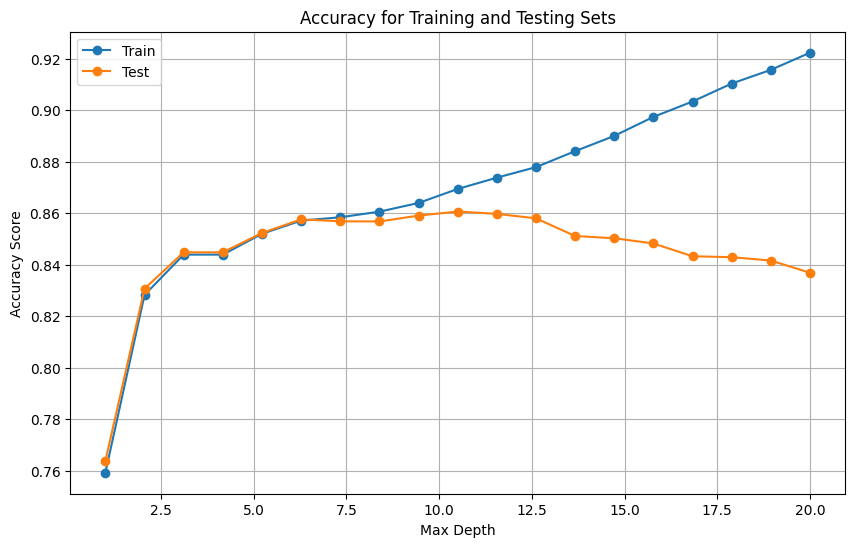

In [6]:
from sklearn.tree import DecisionTreeClassifier

# Initialize lists
accuracy_train = []
accuracy_test = []

# Loop over different max_depth values and compute accuracies
for i in range(1,20):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train_encoded, Ytrain)
    
    # Train set
    accuracy_train.append(accuracy_score(Ytrain, clf.predict(X_train_encoded)))
    
    # Test set
    accuracy_test.append(accuracy_score(Ytest, clf.predict(X_test_encoded)))
    
# Plotting
plt.figure(figsize=(10, 6))

# x-axis
x = np.linspace(1, 20, 19)


plt.plot(x, accuracy_train, label='Train', marker='o')
plt.plot(x, accuracy_test, label='Test', marker='o')

plt.title('Accuracy for Training and Testing Sets')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

Underfitting and overfitting in random forests classifiers

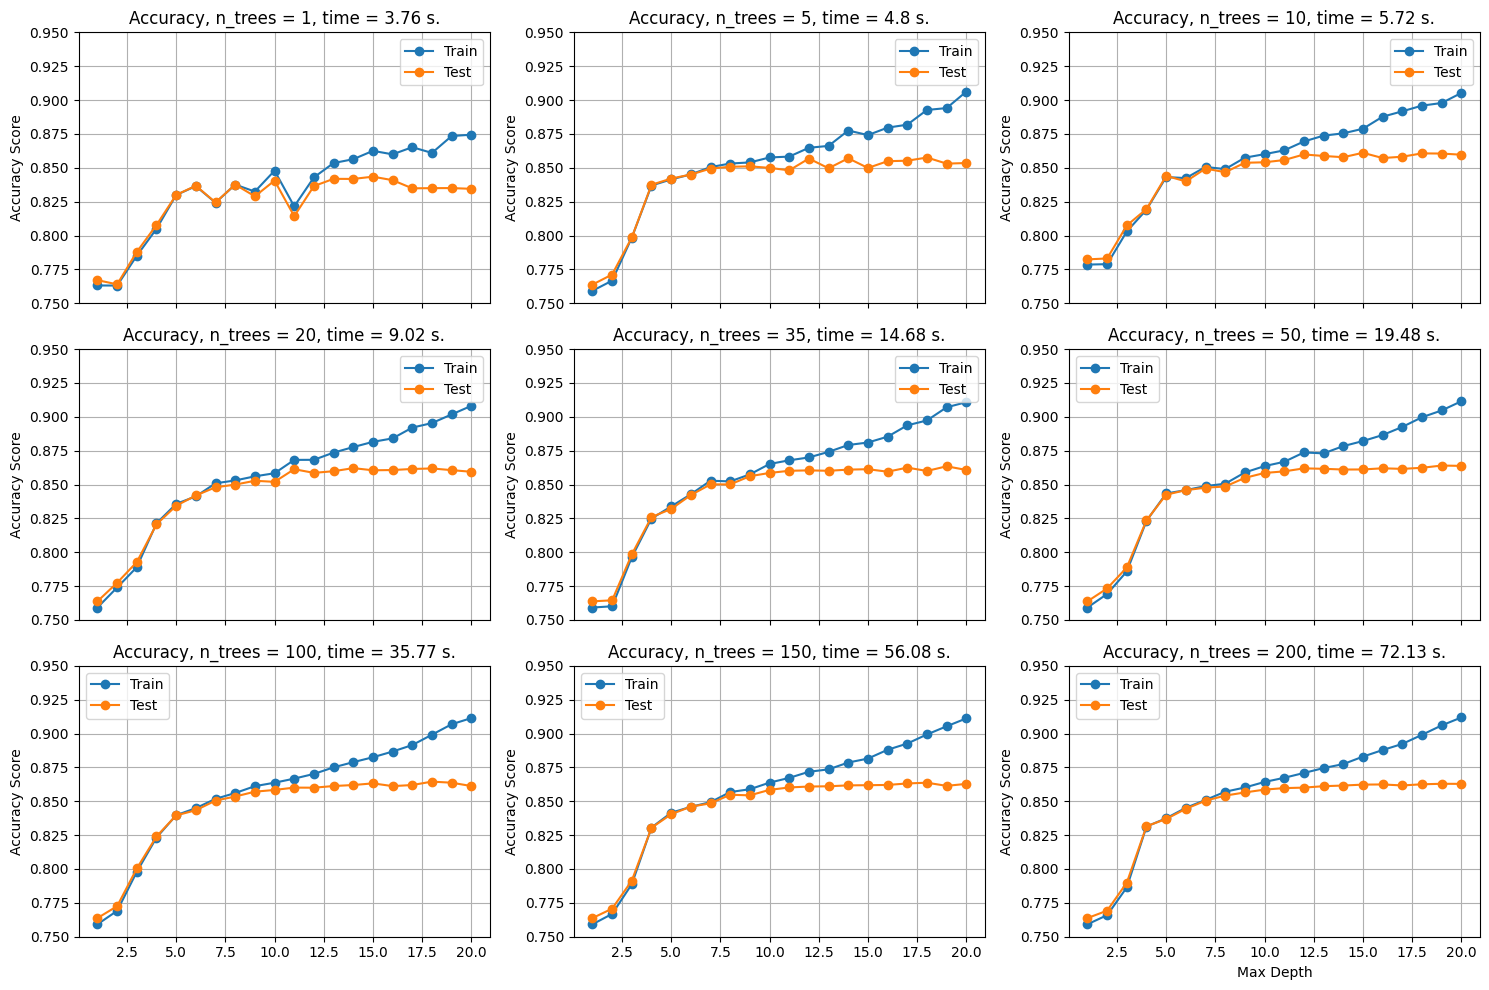

In [7]:
from sklearn.ensemble import RandomForestClassifier
import time
# Max depth
max_d = 20

# List of different numbers of trees we're gonna try
n_trees = [1, 5, 10, 20, 35, 50, 100,150,200]

# Initialize lists
accuracy_train = [[] for _ in range(len(n_trees))]
accuracy_test = [[] for _ in range(len(n_trees))]
times = []

# Create a grid of subplots
n_cols=3
n_rows= np.ceil(len(n_trees)/n_cols).astype(int)
fig, axs = plt.subplots(n_rows,n_cols, figsize=(15, 10), sharex=True)

# Flatten the axs array to iterate over it properly
axs_flat = axs.flatten()

# Loop over different max_depth values and compute accuracies
for j in range(len(n_trees)):
    
    # Calculate training time
    t0 = time.time()
    
    for i in range(1, max_d + 1):
        clf = RandomForestClassifier(n_estimators=n_trees[j], n_jobs=-1, max_depth=i)
        clf.fit(X_train_encoded, Ytrain)

        # Train set
        accuracy_train[j].append(accuracy_score(Ytrain, clf.predict(X_train_encoded)))

        # Test set
        accuracy_test[j].append(accuracy_score(Ytest, clf.predict(X_test_encoded)))
        
    times.append(time.time() - t0)
    
    # Plotting in the respective subplot
    axs_flat[j].plot(np.linspace(1, max_d, max_d), accuracy_train[j], label='Train', marker='o')
    axs_flat[j].plot(np.linspace(1, max_d, max_d), accuracy_test[j], label='Test', marker='o')

    axs_flat[j].set_title(f'Accuracy, n_trees = {n_trees[j]}, time = {round(times[j],2)} s.')
    axs_flat[j].set_ylabel('Accuracy Score')
    axs_flat[j].legend()
    axs_flat[j].set_ylim(0.75, 0.95)  # Set y-axis limits
    axs_flat[j].grid(True)

# Set common labels and show the plot
plt.xlabel('Max Depth')
plt.tight_layout()
plt.show()

The curve for a decision tree and a random forest with an ensemble size of 1 would likley show a difference. A decision tree would tend to overfit the training data, creating a complex model that captures noise. A random forest with only one tree behaves similarly to an individual decision tree. The difference if found in the random forest's ability to reduce overfitting by averaging predictions from multiple trees even if the ensemble size is minimal. The random forest with an ensemble size of 1 might show better generalization compared to individual decision tree.

As the ensemble size of the random forest grows the model tends to generalize better. With a small ensemble size the model may not capture the full complexity of the underlying data patterns caused by high variance. As more trees are added to the ensemble the variance decreases resulting in a more robust model. 

The test set accuracy is likely to improve as the ensemble size of the random forest increases up to a certain point. The model maybe wont capture all the variations of the data if ensemble is small, which leads to underfitting. As the ensemble size increases the model becomes more capable of capturing complex patterns, reducing underfitting and improving test set accuracy. This is only valid up to a certain number of trees and adding more trees might nor enhance performance.

The training time increases as the ensemble size grows. Additional trees in the random forest requires additional computational time. The random forest can be trained more efficiently by adjusting the n_jobs hyperparameter which determines the number of CPU cores used for training. A larger ensemble size leads to longer training times but the trade-off is a potentially more accurate and robust model.

<p align="center"><font size="6">Task 3</font></p>

In [8]:
# Trained random forest classifier
random_forest_classifier = pipeline.steps[1][1]

# Feature importances and feature names
importances = random_forest_classifier.feature_importances_
feature_names = pipeline.steps[0][1].get_feature_names_out()

# Dictionary with feature names to importances
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance in reverse order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top features and their importance scores
num_top_features = 5
for feature, importance in sorted_features[:num_top_features]:
    print(f"Feature: {feature}, Importance: {round(importance,2)}")

Feature: marital-status=Married-civ-spouse, Importance: 0.38
Feature: capital-gain, Importance: 0.2
Feature: education-num, Importance: 0.2
Feature: age, Importance: 0.06
Feature: capital-loss, Importance: 0.06


While decision tree-based importance scores offer insights into features, considering alternative methods may be taken into account. One suc alternative is the permutation importance which involves randomly shuffling the values of a single feature and measuring the impact on the model performance. The change in perfomrance provide a more direct measure of the features contribution.